# Projections plot of all variables
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_future = slice('2015','2100')
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load results

In [3]:
list_models = u.get_model_names_projections()
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

var_list = ['tas', 'snc', 'pr']

obs_ym_regrid_zones = [None]*len(var_list)
mm_past_ym_zones = [None]*len(var_list)
mm_future_ym_zones_scenarios = [None]*len(var_list)

for i, var in enumerate(var_list):
    obs_ym_regrid_zones[i] = xr.open_dataarray('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_obs_ym_regrid_zones.nc')
    mm_past_ym_zones[i] = xr.open_dataarray('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
    mm_future_ym_zones_scenarios[i] = xr.open_dataarray('results/projections_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Plot

## Add custom colors for Boxplot in Proplot
Not implemented yet, see this links for more infos:
- https://github.com/lukelbd/proplot/issues/217
- https://github.com/lukelbd/proplot/pull/218/commits/e34628250e74634ecc25e7f41684b05a2bdb0d30

In [5]:
import matplotlib.patches as mpatches

# https://stackoverflow.com/questions/33371939/calculate-rgb-equivalent-of-base-colors-with-alpha-of-0-5-over-white-background
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def bbplot_custom_colors(bplot, ax):
    for key, icolor in (('boxes', colors), ('caps', colors), ('whiskers', colors),
                        ('means', colors), ('medians', colors), ('fliers', colors)):
        artists = bplot[key]
        for i, artist in enumerate(artists):
            if key in ['caps', 'whiskers']:
                artist.set_color(icolor[i//2])
                artist.set_markeredgecolor(icolor[i//2])
            elif key not in ['boxes']:
                artist.set_color(icolor[i])
                artist.set_markeredgecolor(icolor[i])
            if key == 'boxes':
                c = make_rgb_transparent(list(plot.colors.to_rgb(icolor[i])), [1, 1, 1], 0.5)
                artist.set_color(c)
                artist.set_markeredgecolor(c)
                patch = mpatches.PathPatch(
                    artist.get_path(), 
                    color=c
                )
                ax.add_artist(patch)

# HMA plot

scenario
ssp126    1.902715
ssp245    3.438678
ssp370    5.183046
ssp585    6.637889
dtype: float64
scenario
ssp126    0.509595
ssp245    0.745698
ssp370    1.241494
ssp585    1.517648
dtype: float64
scenario
ssp126   -10.334988
ssp245   -18.703920
ssp370   -28.650763
ssp585   -34.829311
dtype: float64
scenario
ssp126    4.109864
ssp245    5.064770
ssp370    8.354959
ssp585    8.998019
dtype: float64
scenario
ssp126     9.438772
ssp245    13.374972
ssp370    19.204520
ssp585    27.054114
dtype: float64
scenario
ssp126     5.011477
ssp245     6.543949
ssp370    10.670219
ssp585    13.330185
dtype: float64


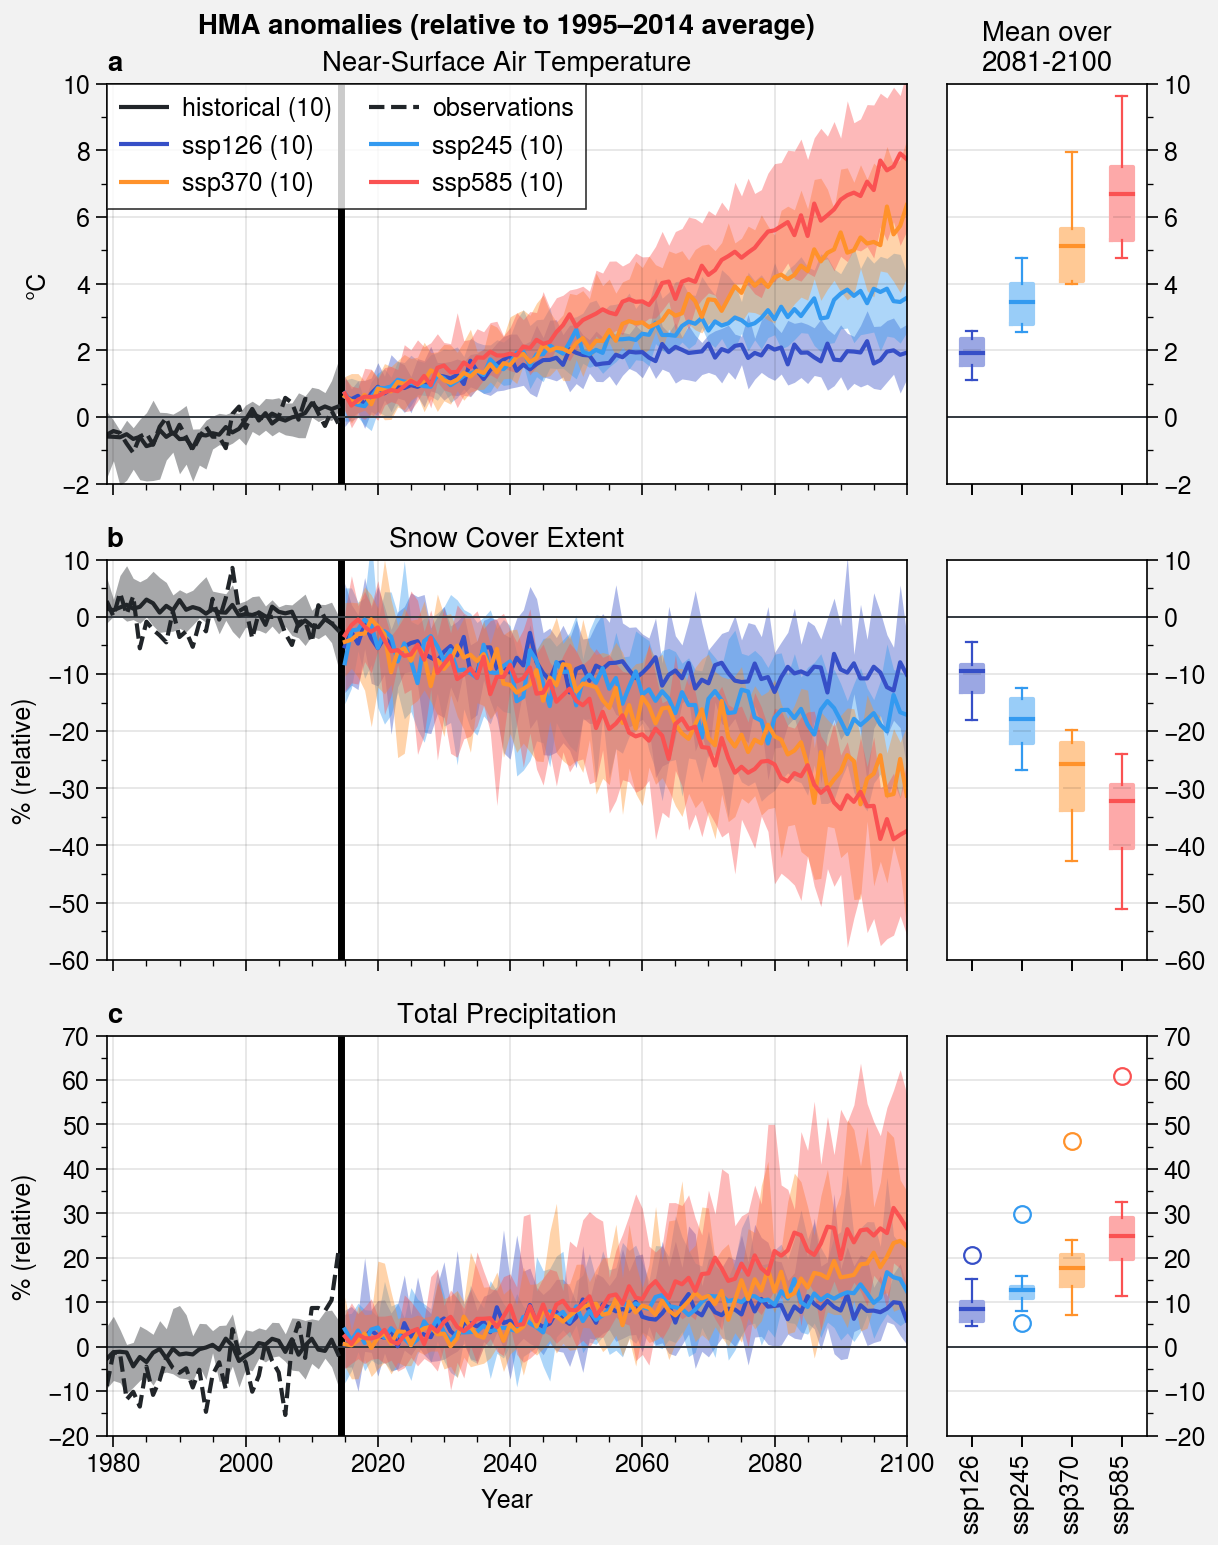

In [14]:
fig, axs = plot.subplots(aspect=2, axwidth=4, ncols=1, nrows=3, sharey=0)

# cols -> zones
# rows -> variables 

collabels = ['Near-Surface Air Temperature', 'Snow Cover Extent', 'Total Precipitation']
units = ['°C', '% (relative)', '% (relative)']
# obs_names = ['CRU', 'NOAA CDR', 'APHRODITE']

k = 0
for zone in ['HMA']:
# zone = 'HMA'
# ymin = -4.5
# ymax = 11
    for i, var in enumerate(var_list):

        if var == 'tas':
            ymin = -2
            ymax = 10
            ylocator = 2
            yminorlocator = 1.000001
        elif var == 'snc':
            ymin = -60
            ymax = 10
            ylocator = 10
            yminorlocator = 5
        elif var == 'pr':
            ymin = -20
            ymax = 70
            ylocator = 10
            yminorlocator = 5
            
        #################################
        ### Compute the anomalies ###
        #################################
        clim_models = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        clim_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        
        # Compute relative anomalies for precipitation
        if var == 'pr':
            anomalies_model = (mm_past_ym_zones[i].sel(zone=zone, season=seasons[0]) - clim_models) / clim_models * 100
            anomalies_obs = (obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0]) - clim_obs) / clim_obs * 100
        else:
            anomalies_model = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0]) - clim_models
            anomalies_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0]) - clim_obs

        ###################
        ### Models past ###
        ###################
        h_past = axs[k].plot(
            anomalies_model.median('model'), shadedata=(anomalies_model).quantile([0.05, 0.95], dim='model'), # 90% CI
            label='historical ('+str(len(list_models))+')', color='gray9'
        )


        ###########
        ### Obs ###
        ###########
        h_obs = axs[k].plot(
            anomalies_obs, 
            label='observations', color='gray9', linestyle='--'
        )


        #####################
        ### Models future ###
        #####################
        colors = ['indigo9', 'blue5', 'orange5', 'red6']
        h_future = [None]*len(scenarios)

        for j, scenario in enumerate(scenarios):
            if var in ['pr', 'snc']:
                anomalies_model_future = (mm_future_ym_zones_scenarios[i].sel(zone=zone, season=seasons[0], scenario=scenario) - clim_models) / clim_models * 100
            else:
                anomalies_model_future = mm_future_ym_zones_scenarios[i].sel(zone=zone, season=seasons[0], scenario=scenario) - clim_models

            h_future[j] = axs[k].plot(
                anomalies_model_future.median('model'), shadedata=(anomalies_model_future).quantile([0.05, 0.95], dim='model'), # 90 % CI
                label=scenario+' ('+str(len(list_models))+')', color=colors[j]
            )


        #############
        ### Panel ###
        #############

        # Prepare data
        data = pd.DataFrame(
            None,
            columns=pd.Index(scenarios, name='scenario')
        )
        for scenario in scenarios:
            if var in ['pr', 'snc']:
                data[scenario] = ((mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models) / clim_models * 100).values
            else:
                data[scenario] = (mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

        # Make panel
        pax = axs[k].panel('r', width=1, space=0.2, share=0)

        # Plot boxplots
        bplot = pax.boxplot(data, medianlw=1.5, boxlw=1.5, showcaps=True, 
#                             whis=[5, 95]
                           )
        
        # Print values
        print(data.mean())
        print(data.std())
        
        # Fix bug (or not implement custom colors for boxplots in proplot, see function above)
        bbplot_custom_colors(bplot, pax)

        # Format
        pax.format(
            grid=False, ygrid=True, 
            ylocator=ylocator, yminorlocator=yminorlocator, ylim=(ymin,ymax),
            xrotation=90, 
        )

        if k in [0]:
            pax.format(
                title='Mean over\n2081-2100'
            )
            
            axs[k].legend(
                [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
                loc='ul', frame=True, ncols=2
            )

        #############
        ### Lines ###
        #############
        axs[k].vlines(2014.5, ymin, ymax, linewidth=2.5)
        axs[k].hlines(0, 1979, 2100, linewidth=0.7, color='gray8')
        pax.hlines(0, -0.5, 3.5, linewidth=0.7, color='gray8')
        pax.autoscale(enable=True, axis="x", tight=True)


        ##############
        ### Format ###
        ##############
        axs[k].format(
            title=collabels[i],
            ylabel=units[i], ylocator=ylocator, yminorlocator=yminorlocator, ylim=(ymin,ymax),
            xlabel='Year', xminorlocator=5, xlocator=20
        )
        
        k += 1
        
axs.format(
    suptitle='HMA anomalies (relative to 1995–2014 average)',
    abc=True
)

# ##############
# ### Legend ###
# ##############
# fig.legend(
#     [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
#     loc='b', frame=True, ncols=6
# )

filename = 'projections/HMA_projections'
# fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

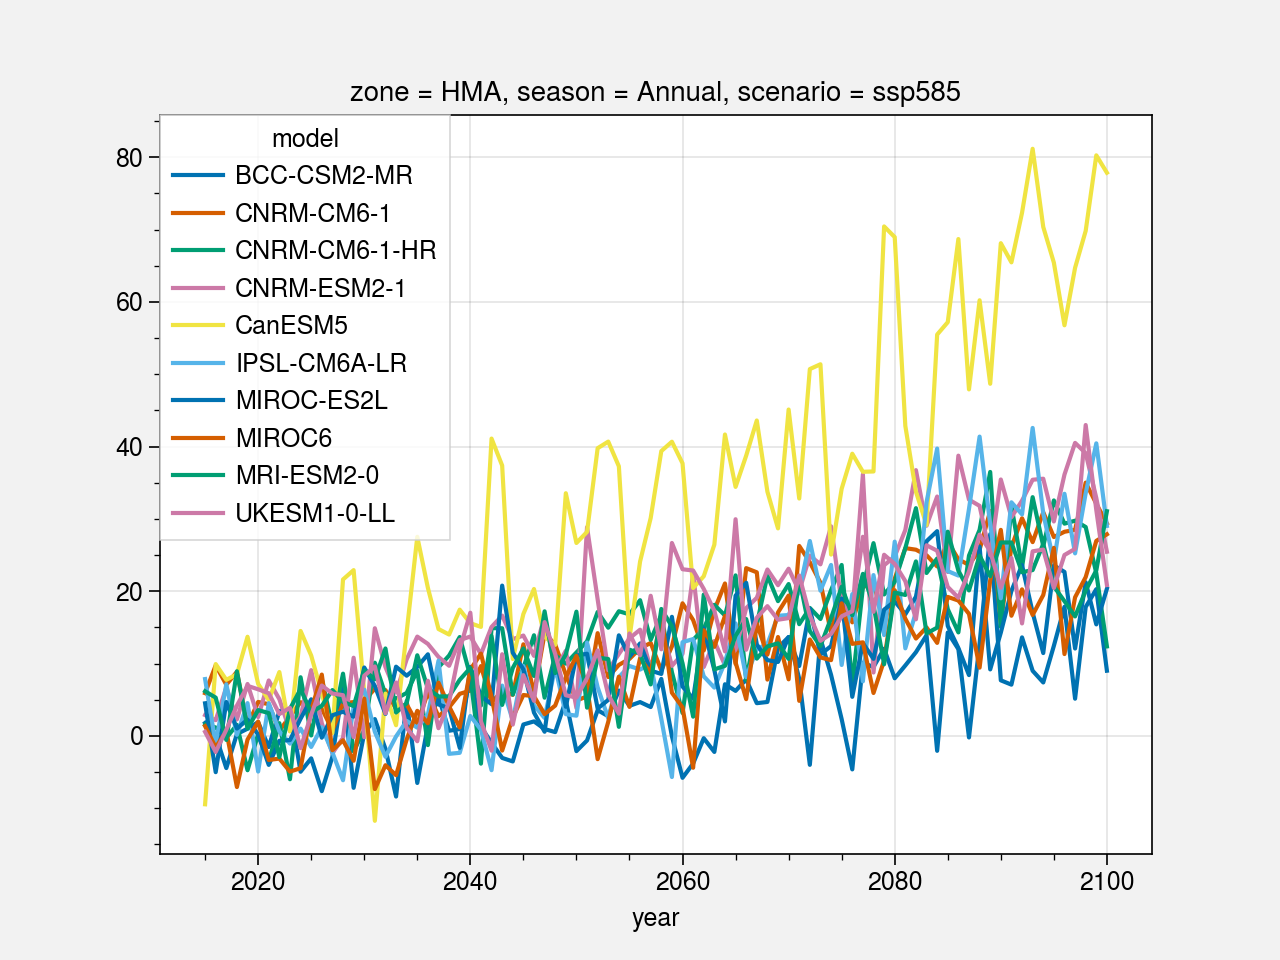

In [17]:
anomalies_model_future.plot(hue='model')

## Print values

In [4]:
for zone in ['HMA']:

    for i, var in enumerate(var_list):

        #################################
        ### Compute the anomalies ###
        #################################
        clim_models = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        clim_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')

        #############
        ### Panel ###
        #############

        # Prepare data
        data = pd.DataFrame(
            None,
            columns=pd.Index(scenarios, name='scenario')
        )
        for scenario in scenarios:
            if var == 'pr':
                data[scenario] = ((mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models) / clim_models * 100).values
            else:
                data[scenario] = (mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

        # Plot boxplots
        print(data.quantile([0.05, 0.5, 0.95]))      


scenario    ssp126    ssp245    ssp370    ssp585
0.05      1.228314  2.590696  4.001302  4.980774
0.50      1.922103  3.447966  5.142160  6.685442
0.95      2.562888  4.483682  7.090988  8.777824
scenario    ssp126     ssp245     ssp370     ssp585
0.05     -8.438371 -12.894384 -20.318008 -23.683372
0.50     -4.300968  -6.840165 -11.216011 -14.284678
0.95     -2.368867  -5.800229  -9.195046  -9.870207
scenario     ssp126     ssp245     ssp370     ssp585
0.05       4.835425   6.590630   9.010359  14.451980
0.50       8.498920  12.864178  17.634601  24.873821
0.95      18.190216  23.637962  36.216859  48.102082


In [37]:
for zone in ['HMA']:

    for i, var in enumerate(var_list):

        #################################
        ### Compute the anomalies ###
        #################################
        clim_models = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        clim_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')

        #############
        ### Panel ###
        #############

        # Prepare data
        data = pd.DataFrame(
            None,
            columns=pd.Index(scenarios, name='scenario')
        )
        for scenario in scenarios:
            if var == 'pr':
                data[scenario] = ((mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models) / clim_models * 100).values
            else:
                data[scenario] = (mm_future_ym_zones_scenarios[i].sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

        # Plot boxplots
        print(data.drop(4).quantile([0.05, 0.5, 0.95]))      


scenario    ssp126    ssp245    ssp370    ssp585
0.05      1.215277  2.586732  3.999520  4.957070
0.50      1.861241  3.316114  4.948764  6.181204
0.95      2.509272  4.105465  5.879738  7.661999
scenario    ssp126     ssp245     ssp370     ssp585
0.05     -8.608151 -13.103727 -18.981259 -22.758351
0.50     -4.045285  -6.833841 -10.862597 -13.211559
0.95     -2.368203  -5.770288  -9.166904  -9.786544
scenario     ssp126     ssp245     ssp370     ssp585
0.05       4.808903   6.458657   8.812346  14.109731
0.50       8.153702  12.658041  17.401953  24.185298
0.95      13.128872  14.905443  22.900793  31.324645


In [ ]:
if var == 'pr':
    ((mm_future_ym_zones_scenarios[i].sel(
        zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models) / clim_models * 100).quantile([0.05, 0.95], dim='model').values
else:
    (mm_future_ym_zones_scenarios[i].sel(
        zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).quantile([0.05, 0.95], dim='model').values

In [25]:
test = data.copy()

In [28]:
test.drop(4).quantile([0.05, 0.5, 0.95])

scenario,ssp126,ssp245,ssp370,ssp585
0.05,4.808903,6.458657,8.812346,14.109731
0.50,8.153702,12.658041,17.401953,24.185298
0.95,13.128872,14.905443,22.900793,31.324645


In [34]:
print(test)
print(test)

scenario     ssp126     ssp245     ssp370     ssp585
0          4.596729   5.402868   7.228237  11.371737
1          8.153702  12.658041  17.401953  27.118358
2          8.844137  13.070315  18.701228  25.562343
3         10.065452  15.917085  23.963543  32.561436
4         20.660360  29.955043  46.242299  60.817156
5          5.127163  13.387978  21.306668  29.469460
6          6.472641  10.896995  13.392784  18.216723
7          5.697988   8.042340  11.188509  18.912305
8          9.598392  11.070891  14.752726  22.326324
9         15.171151  13.348160  17.867249  24.185298
scenario     ssp126     ssp245     ssp370     ssp585
0          4.596729   5.402868   7.228237  11.371737
1          8.153702  12.658041  17.401953  27.118358
2          8.844137  13.070315  18.701228  25.562343
3         10.065452  15.917085  23.963543  32.561436
4         20.660360  29.955043  46.242299  60.817156
5          5.127163  13.387978  21.306668  29.469460
6          6.472641  10.896995  13.392784  18.

In [22]:
data.quantile([0.05, 0.5, 0.95])

scenario,ssp126,ssp245,ssp370,ssp585
0.05,4.835425,6.590630,9.010359,14.451980
0.50,8.498920,12.864178,17.634601,24.873821
0.95,18.190216,23.637962,36.216859,48.102082


# All zones plot

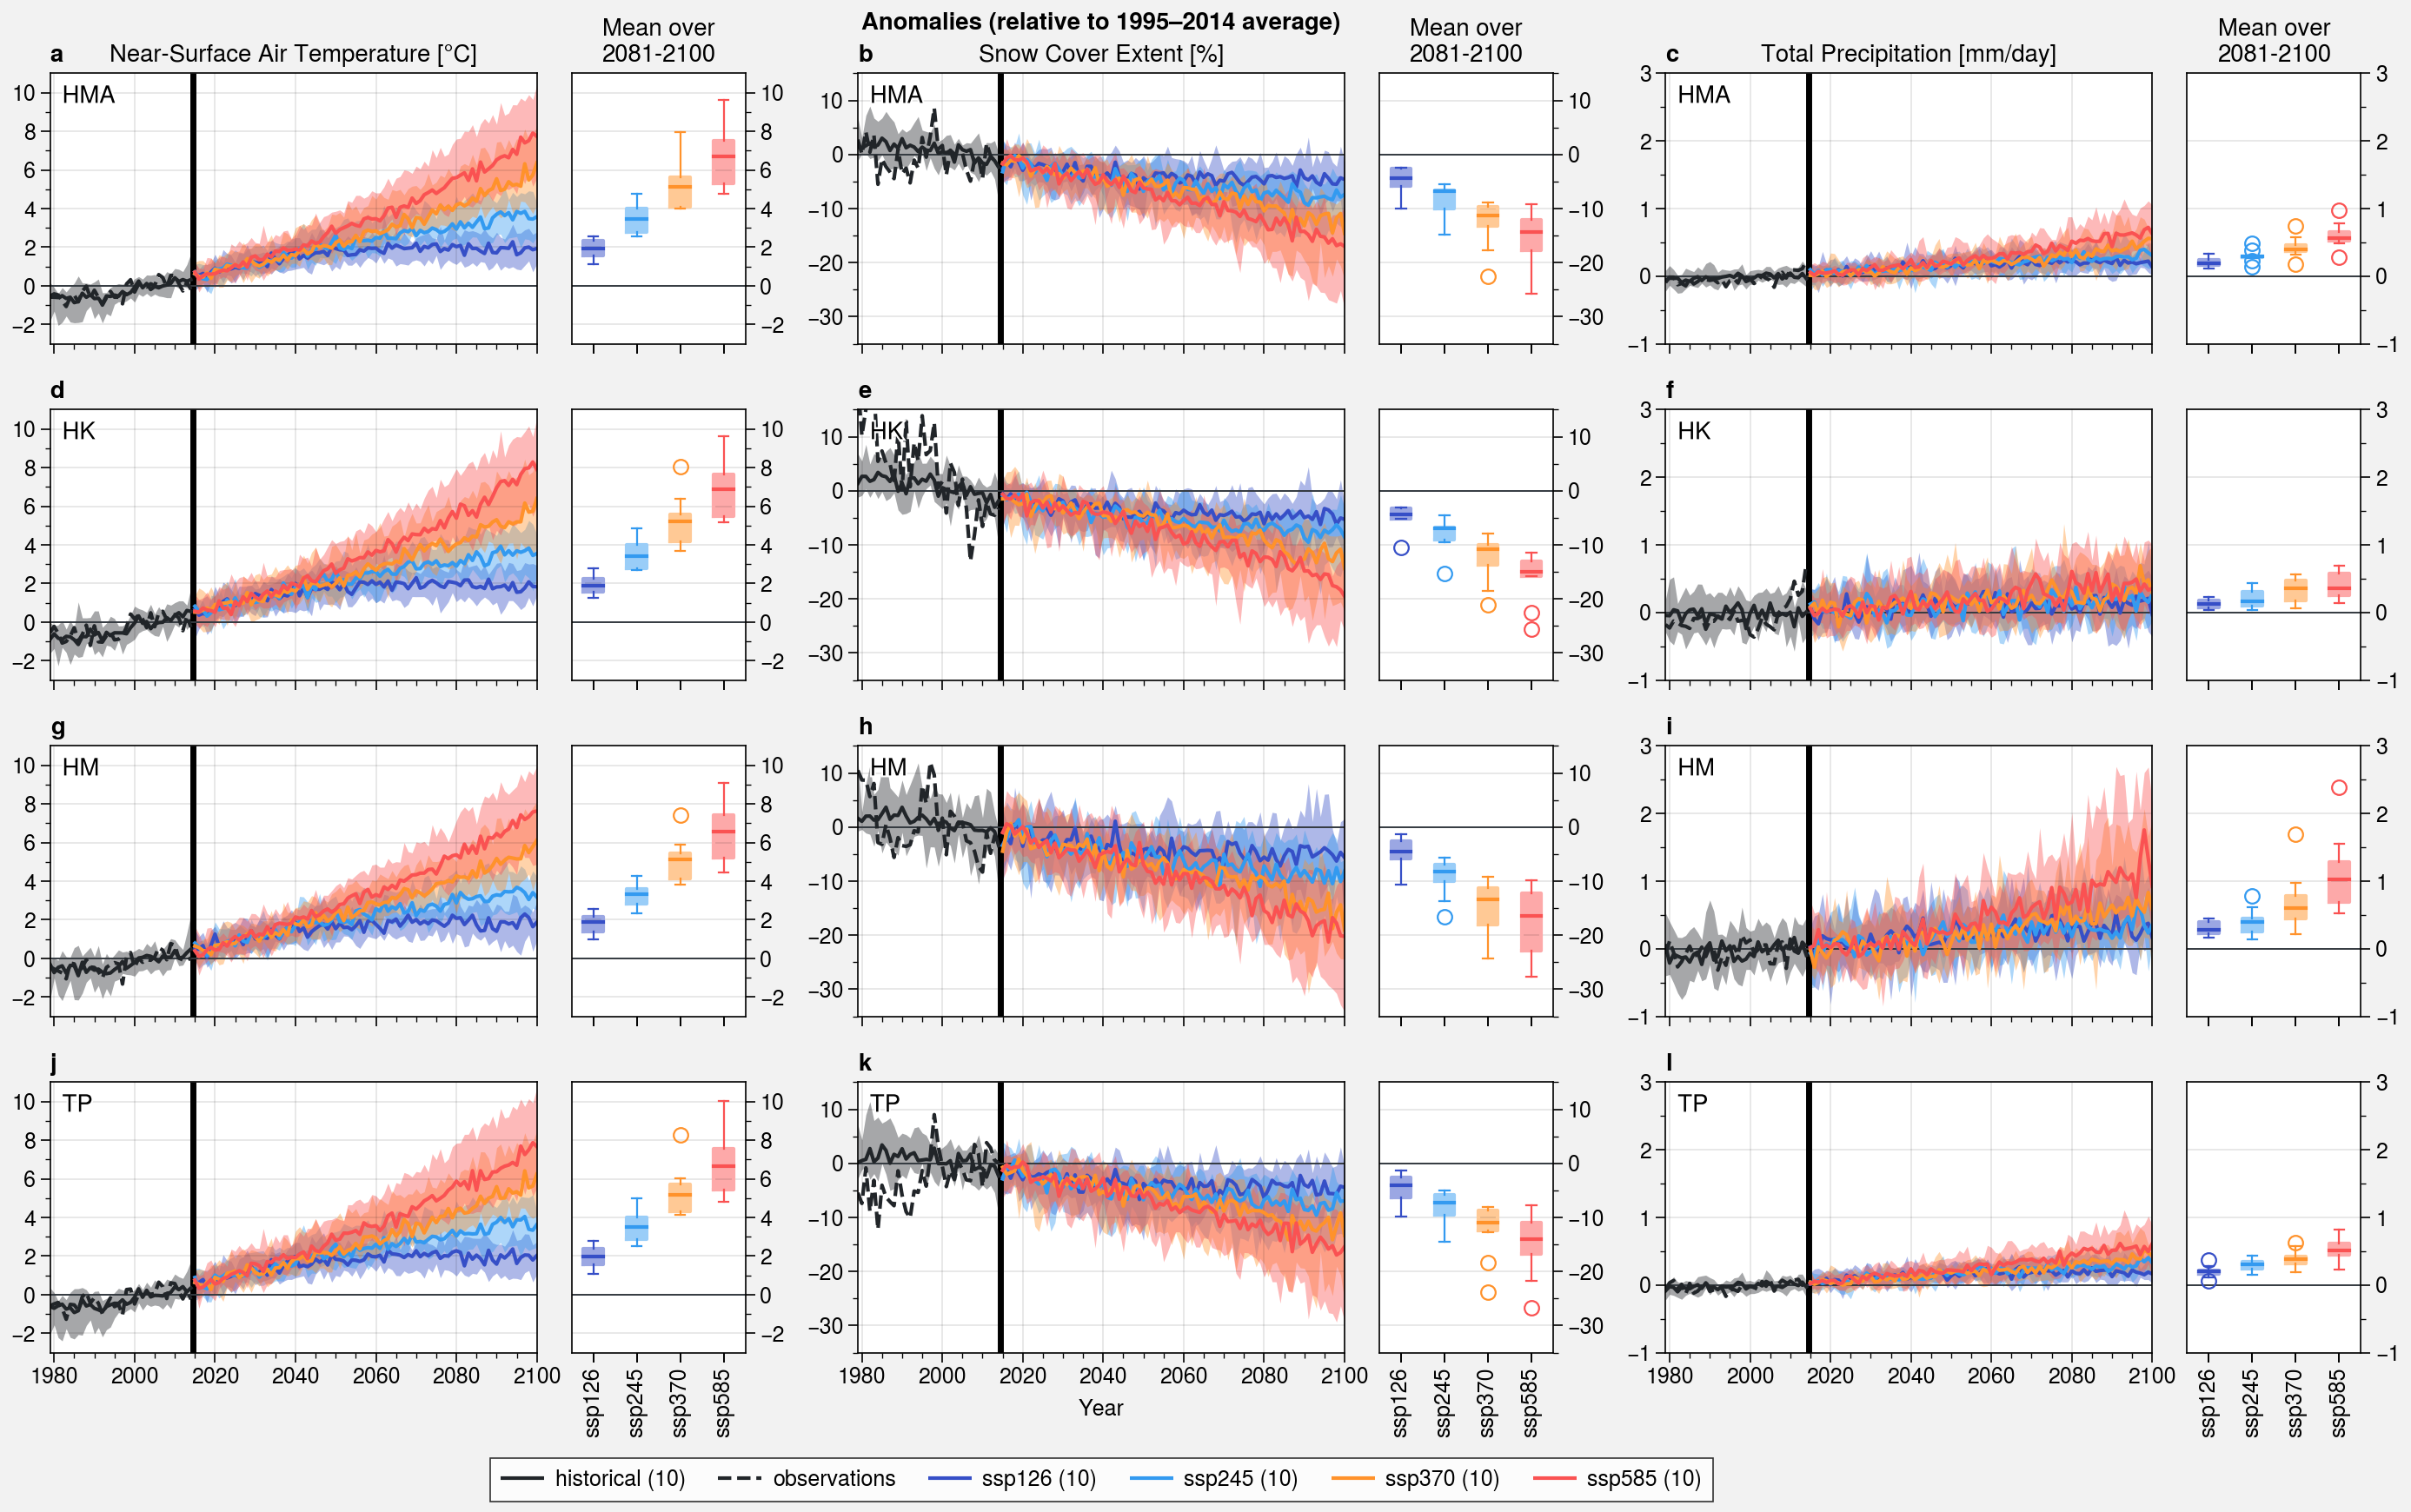

In [5]:
fig, axs = plot.subplots(aspect=1.8, axwidth=2.8, ncols=3, nrows=4, sharey=0)

# cols -> zones
# rows -> variables 

collabels = ['Near-Surface Air Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']
# obs_names = ['CRU', 'NOAA CDR', 'APHRODITE']

k = 0
for zone in zones:
# zone = 'HMA'
# ymin = -4.5
# ymax = 11
    for i, var in enumerate(var_list):

        if var == 'tas':
            ymin = -3
            ymax = 11
            ylocator = 2
            yminorlocator = 1.000001
        elif var == 'snc':
            ymin = -35
            ymax = 15
            ylocator = 10
            yminorlocator = 5
        elif var == 'pr':
            ymin = -1
            ymax = 3
            ylocator = 1
            yminorlocator = 0.5
            
        #################################
        ### Compute the anomalies ###
        #################################
        clim_models = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        anomalies_model = mm_past_ym_zones[i].sel(zone=zone, season=seasons[0]) - clim_models

        clim_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
        anomalies_obs = obs_ym_regrid_zones[i].sel(zone=zone, season=seasons[0]) - clim_obs

        ###################
        ### Models past ###
        ###################
        h_past = axs[k].plot(
            anomalies_model.median('model'), shadedata=(anomalies_model).quantile([0.05, 0.95], dim='model'), # 90% CI
            label='historical ('+str(len(list_models))+')', color='gray9'
        )


        ###########
        ### Obs ###
        ###########
        h_obs = axs[k].plot(
            anomalies_obs, 
            label='observations', color='gray9', linestyle='--'
        )


        #####################
        ### Models future ###
        #####################
        colors = ['indigo9', 'blue5', 'orange5', 'red6']
        h_future = [None]*len(scenarios)

        for j, scenario in enumerate(scenarios):
            anomalies_model_future = mm_future_ym_zones_scenarios[i].sel(zone=zone, season=seasons[0], scenario=scenario) - clim_models

            h_future[j] = axs[k].plot(
                anomalies_model_future.median('model'), shadedata=(anomalies_model_future).quantile([0.05, 0.95], dim='model'), # 90 % CI
                label=scenario+' ('+str(len(list_models))+')', color=colors[j]
            )


        #############
        ### Panel ###
        #############

        # Prepare data
        data = pd.DataFrame(
            None,
            columns=pd.Index(scenarios, name='scenario')
        )
        for scenario in scenarios:
            data[scenario] = (mm_future_ym_zones_scenarios[i].sel(
                zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

        # Make panel
        pax = axs[k].panel('r', width=1, space=0.2, share=0)

        # Plot boxplots
        bplot = pax.boxplot(data, medianlw=1.5, boxlw=1.5, showcaps=True)
        # Fix bug (or not implement custom colors for boxplots in proplot, see function above)
        bbplot_custom_colors(bplot, pax)

        # Format
        pax.format(
            grid=False, ygrid=True, 
            ylocator=ylocator, yminorlocator=yminorlocator, ylim=(ymin,ymax),
            xrotation=90, 
        )

        if k in [0, 1, 2]:
            pax.format(
                title='Mean over\n2081-2100'
            )

        #############
        ### Lines ###
        #############
        axs[k].vlines(2014.5, ymin, ymax, linewidth=2.5)
        axs[k].hlines(0, 1979, 2100, linewidth=0.7, color='gray8')
        pax.hlines(0, -0.5, 3.5, linewidth=0.7, color='gray8')
        pax.autoscale(enable=True, axis="x", tight=True)


        ##############
        ### Format ###
        ##############
        axs[k].format(
            ultitle=zone,
            title='', 
            ylabel='', ylocator=ylocator, yminorlocator=yminorlocator, ylim=(ymin,ymax),
            xlabel='Year', xminorlocator=5, xlocator=20
        )

        if k in [0, 1, 2]:
            axs[k].format(
                title=collabels[k], 
                ylabel='', ylocator=ylocator, yminorlocator=yminorlocator, ylim=(ymin,ymax),
                xlabel='Year', xminorlocator=5, xlocator=20
            )
        
        k += 1
        
axs.format(
    suptitle='Anomalies (relative to 1995–2014 average)',
    abc=True
)

##############
### Legend ###
##############
fig.legend(
    [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
    loc='b', frame=True, ncols=6
)

filename = 'projections/all_projections'
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')